# Full Model - Airline Profit

In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

## Revenue Model

#### EcoFly seat(Eco)
- Price of EcoFly seat is denoted by $P_{Eco}$, in code Eco_p.
- Demand of EcoFly seat is denoted by $D_{Eco}$, in code Eco_d.

#### FlexFly seat(Flex)
- Price of FlexFly seat is denoted by $P_{Flex}$, in code Flex_p.
- Demand of FlexFly seat is denoted by $P_{Flex}$, in code Flex_d.

#### PrimeFly seat(Prime)
- Price of PrimeFly seat is denoted by $P_{Prime}$, in code Prime_p.
- Demand of PrimeFly seat is denoted by $P_{Prime}$, in code Prime_d.

#### Business seat(Business)
- Price of Business seat is denoted by $P_{Business}$, in code Business_p.
- Demand of Business seat is denoted by $P_{Business}$, in code Business_d.

#### Capacity
- Capacity of the aircraft is denoted by $C$, in code capacity.
- Capacity of the Economy seats in the aircraft is denoted by $C_E$, in code capacity_eco.
- Capacity of the Business seats in the aircraft is denoted by $C_B$, in code capacity_business.

#### Decision Variables
- Number of EcoFly seats sold is denoted by $N_{Eco}$, in code $Eco$.
- Number of FlexFly seats sold is denoted by $N_{Flex}$, in code $Flex$.
- Number of PrimeFly seats sold is denoted by $N_{Prime}$, in code $Prime$.
- Number of Business seats sold is denoted by $N_{Business}$, in code $Business$.

#### Objective Function:
$$ \text{Maximize} \hspace{1em} P_{Eco} \cdot N_{Eco} + P_{Flex} \cdot N_{Flex} +P_{Prime} \cdot N_{Prime} + P_{Business} \cdot N_{Business}$$

#### Constraints:
$$\begin{align*}    
        \text{Subject to} \hspace{1em} & N_{Eco} + N_{Flex} + N_{Prime}+N_{Business} \leq C \\
        & N_{Eco} + N_{Flex} + N_{Prime} \leq C_{Economy} \\
        & N_{Business} \leq C_{Business}  \\
        & N_{Eco} \leq D_{Eco} \\
        & N_{Flex} \leq D_{Flex} \\
        & N_{Prime} \leq D_{Prime} \\
        & D_{Eco}, D_{Flex}, D_{Prime},D_{Business}\geq 0 \\
\end{align*}$$




## Fleet Model

### Sets and Indices
- Let $F$ denote the set of flight legs (e.g., IST-YVR, YVR-IST, etc.), indexed by $i \in F$.
- Let $K$ denote the set of aircraft fleet types (e.g., B777-300ER, B787-9), indexed by $j \in K$.
- Let $P$ denote the set of paired (outbound, return) flight legs, where each pair is indexed by $(i, i') \in P$ (e.g., (TK75, TK76)).

### Parameters (Inputs)
- $d_i$: distance of flight leg $i$ (miles)
- $h_i$: block time of flight leg $i$ (hours), computed as
  $$
  h_i = \frac{d_i}{v}
  $$
  where $v$ is an assumed constant cruise speed
- $N_j$: number of available aircraft of fleet type $j$
- $\text{fuel}_j$: fuel burn rate of fleet type $j$ (kg/hour)
- $\text{crew}_j$: crew cost rate of fleet type $j$ ($\$$/hour)
- $\text{maint}_j$: maintenance/other operating cost rate of fleet type $j$ (USD/hour)
- $p_{\text{fuel}}$: fuel price ($\$$/kg)
- $H_{\max}$: maximum usable crew-hours (block hours) per aircraft per day
- $\text{range}_j$: maximum feasible flight range of fleet type $j$ (miles)

Define the per-assignment operating cost $c_{i,j}$ as:
$$
c_{i,j} =
\left(\text{fuel}_j \cdot p_{\text{fuel}} + \text{crew}_j + \text{maint}_j\right)\cdot h_i
$$

### Decision Variables
- $x_{i,j} \in \{0,1\}$  
  $x_{i,j} = 1$ if flight $i$ is assigned fleet type $j$, and $0$ otherwise.

### Constraints

#### 1. Flight Coverage
Each flight leg must be assigned to exactly one fleet type:
$$
\sum_{j \in K} x_{i,j} = 1 \quad \forall i \in F
$$

#### 2. Crew-Hour availability by Fleet Type
Each aircraft of fleet type $j$ is assumed to operate at most $H_{\max}$ crew-hours per day.  
Because each assigned flight would have crew-hours equal to its block time, total crew-hours used by fleet type $j$ cannot exceed available crew-hours:
$$
\sum_{i \in F} h_i\, x_{i,j} \le N_j \cdot H_{\max} \quad \forall j \in K
$$

#### 3. Aircraft Range Feasibility
A fleet type may only be assigned to flight legs within its operational range. If the route distance exceeds the aircraft’s maximum range, that assignment is infeasible:
$$
x_{i,j} = 0 \quad \text{if } d_i > \text{range}_j
$$


#### 4. Operational Pairing (Round-Trip Consistency)
For paired outbound and return flight legs $(i,i') \in P$, the same fleet type must be used on both legs to ensure operational consistency:

$$
x_{i,j} = x_{i',j} \quad \forall j \in K,\; \forall (i,i') \in P
$$

### Objective Function
Minimize total operating cost across all flights and fleet types:
$$
\min \sum_{i \in F}\sum_{j \in K} c_{i,j}\,x_{i,j}
$$


## Full model

Our model uses Weighted Sum method to maximize the profit of an airline company based on out other base models, Revenue and Fleet Models.

#### Flight Route Information
- Flight Number: fid
- Origin Airport: orig
- Destination Airport: dest
- Total distance of the flight route in miles: dist_mi
- Class fare price in USD: Eco_p, Flex_p, Prime_p, Bus_p
- Class fare demand: Eco_d, Flex_d, Prime_d, Bus_d

In [2]:
flights = pd.DataFrame([
    {
        "fid": "TK75", "orig": "IST", "dest": "YVR", "dist_mi": 5973.9,
        "Eco_p": 635, "Flex_p": 765, "Prime_p": 920, "Bus_p": 2300,
        "Eco_d": 180, "Flex_d": 120, "Prime_d": 60, "Bus_d": 49
    },
    {
        "fid": "TK76", "orig": "YVR", "dest": "IST", "dist_mi": 5973.9,
        "Eco_p": 635, "Flex_p": 765, "Prime_p": 920, "Bus_p": 2300,
        "Eco_d": 180, "Flex_d": 120, "Prime_d": 60, "Bus_d": 49
    },
    {
        "fid": "TK001", "orig": "IST", "dest": "JFK", "dist_mi": 5000.0,
        "Eco_p": 600, "Flex_p": 760, "Prime_p": 910, "Bus_p": 3100,
        "Eco_d": 180, "Flex_d": 120, "Prime_d": 60, "Bus_d": 49
    },
    {
        "fid": "TK002", "orig": "JFK", "dest": "IST", "dist_mi": 5000.0,
        "Eco_p": 600, "Flex_p": 760, "Prime_p": 910, "Bus_p": 3100,
        "Eco_d": 180, "Flex_d": 120, "Prime_d": 60, "Bus_d": 49
    },
    {
        "fid": "TK193", "orig": "IST", "dest": "LHR", "dist_mi": 1550.0,
        "Eco_p": 140, "Flex_p": 185, "Prime_p": 205, "Bus_p": 900,
        "Eco_d": 140, "Flex_d": 160, "Prime_d": 90, "Bus_d": 50
    },
    {
        "fid": "TK194", "orig": "LHR", "dest": "IST", "dist_mi": 1550.0,
        "Eco_p": 140, "Flex_p": 185, "Prime_p": 205, "Bus_p": 900,
        "Eco_d": 140, "Flex_d": 160, "Prime_d": 90, "Bus_d": 50
    },
    {
        "fid": "TK17", "orig": "IST", "dest": "YYZ", "dist_mi": 5090.0,
        "Eco_p": 600, "Flex_p": 800, "Prime_p": 950, "Bus_p": 2200,
        "Eco_d": 180, "Flex_d": 120, "Prime_d": 60, "Bus_d": 50
    },
    {
        "fid": "TK18", "orig": "YYZ", "dest": "IST", "dist_mi": 5090.0,
        "Eco_p": 600, "Flex_p": 800, "Prime_p": 950, "Bus_p": 2200,
        "Eco_d": 160, "Flex_d": 120, "Prime_d": 60, "Bus_d": 50
    },
    {
        "fid": "TK1821", "orig": "IST", "dest": "CDG", "dist_mi": 1380.0,
        "Eco_p": 195, "Flex_p": 230, "Prime_p": 260, "Bus_p": 1035,
        "Eco_d": 140, "Flex_d": 120, "Prime_d": 90, "Bus_d": 50
    },
    {
        "fid": "TK1830", "orig": "CDG", "dest": "IST", "dist_mi": 1380.0,
        "Eco_p": 195, "Flex_p": 230, "Prime_p": 260, "Bus_p": 1035,
        "Eco_d": 140, "Flex_d": 120, "Prime_d": 90, "Bus_d": 50
    },
    {
        "fid": "TK1523", "orig": "IST", "dest": "DUS", "dist_mi": 1250.0,
        "Eco_p": 140, "Flex_p": 170, "Prime_p": 190, "Bus_p": 800,
        "Eco_d": 150, "Flex_d": 130, "Prime_d": 90, "Bus_d": 50
    },
    {
        "fid": "TK1530", "orig": "DUS", "dest": "IST", "dist_mi": 1250.0,
        "Eco_p": 140, "Flex_p": 170, "Prime_p": 190, "Bus_p": 800,
        "Eco_d": 150, "Flex_d": 130, "Prime_d": 90, "Bus_d": 50
    },
    {
        "fid": "TK1951", "orig": "IST", "dest": "AMS", "dist_mi": 1360.0,
        "Eco_p": 150, "Flex_p": 180, "Prime_p": 190, "Bus_p": 600,
        "Eco_d": 130, "Flex_d": 120, "Prime_d": 110, "Bus_d": 50
    },
    {
        "fid": "TK1952", "orig": "AMS", "dest": "IST", "dist_mi": 1360.0,
        "Eco_p": 150, "Flex_p": 180, "Prime_p": 190, "Bus_p": 600,
        "Eco_d": 130, "Flex_d": 120, "Prime_d": 110, "Bus_d": 50
    },
    {
        "fid": "TK198", "orig": "IST", "dest": "HND", "dist_mi": 5600.0,
        "Eco_p": 970, "Flex_p": 1050, "Prime_p": 1500, "Bus_p": 4600,
        "Eco_d": 170, "Flex_d": 150, "Prime_d": 60, "Bus_d": 50
    },
    {
        "fid": "TK199", "orig": "HND", "dest": "IST", "dist_mi": 5600.0,
        "Eco_p": 970, "Flex_p": 1050, "Prime_p": 1500, "Bus_p": 4600,
        "Eco_d": 170, "Flex_d": 150, "Prime_d": 60, "Bus_d": 50
    },
])

#### Current Fleet - Aircrafts to be used
- Aircraft model: type
- Number of overall seats: seats
- Amount of fuel used kg per hour: fuel_kg_hr
- Maintanace cost in USD per hour: maint_usd_hr
- Pilot salaries in USD per hour: pilot_usd_hr
- Cabin crew salaries in USD per hour: cabin_usd_hr
- Number of avaiable aircrafts of this model: N
- Mileage range of the aircraft model: range_mi
- Number of Business seats in the aircraft: bus_seats
- Number of Economy seats in the aircraft: econ_seats

In [3]:
fleet = pd.DataFrame([
    {
        "type": "B777-300ER", "seats": 349,
        "fuel_kg_hr": 7500, "maint_usd_hr": 2200,
        "pilot_usd_hr": 700, "cabin_usd_hr": 1200,
        "N": 3, "range_mi": 7300,
        "bus_seats": 49, "econ_seats": 300
    },
    {
        "type": "B787-9", "seats": 290,
        "fuel_kg_hr": 8100, "maint_usd_hr": 2000,
        "pilot_usd_hr": 700, "cabin_usd_hr": 800,
        "N": 3, "range_mi": 7600,
        "bus_seats": 30, "econ_seats": 270
    },
    {
        "type": "A330-300", "seats": 291,
        "fuel_kg_hr": 5700, "maint_usd_hr": 2000,
        "pilot_usd_hr": 700, "cabin_usd_hr": 700,
        "N": 3, "range_mi": 6300,
        "bus_seats": 28, "econ_seats": 263
    },
])

In [4]:
#Constants
FUEL_PRICE_USD_PER_KG = 0.90
CRUISE_MPH = 560
H_MAX = 15.0 

flights["hours"] = flights["dist_mi"] / CRUISE_MPH

#### Revenue Model Parameters
Price, demand, and capacity

In [5]:
Eco_p = flights["Eco_p"].values
Flex_p = flights["Flex_p"].values
Prime_p = flights["Prime_p"].values
Bus_p = flights["Bus_p"].values

Eco_d = flights["Eco_d"].values
Flex_d = flights["Flex_d"].values
Prime_d = flights["Prime_d"].values
Bus_d = flights["Bus_d"].values

bus_cap = fleet["bus_seats"].values
econ_cap = fleet["econ_seats"].values

#### Fleet Model Parameters
Cost Matrix

In [6]:
I, J = len(flights), len(fleet)
C = np.zeros((I, J))

for i, f in flights.iterrows():
    for j, a in fleet.iterrows():
        hours = f["hours"]
        fuel_cost = a["fuel_kg_hr"] * hours * FUEL_PRICE_USD_PER_KG
        maint_cost = a["maint_usd_hr"] * hours
        crew_cost = (a["pilot_usd_hr"] + a["cabin_usd_hr"]) * hours
        C[i, j] = fuel_cost + maint_cost + crew_cost

#### Decision Variables
- Revenue Model:
    - Number of EcoFly seats sold is denoted by $N_{Eco}$, in code $Eco$.
    - Number of FlexFly seats sold is denoted by $N_{Flex}$, in code $Flex$.
    - Number of PrimeFly seats sold is denoted by $N_{Prime}$, in code $Prime$.
    - Number of Business seats sold is denoted by $N_{Business}$, in code $Business$.
- Fleet Model:
    - $x_{i,j} \in \{0,1\}$  
  $x_{i,j} = 1$ if flight $i$ is assigned fleet type $j$, and $0$ otherwise.

In [7]:
x = cp.Variable((I, J), boolean=True)  # fleet assignment
Eco = cp.Variable(I, integer=True)     # economy seats sold
Flex = cp.Variable(I, integer=True)    # flex seats sold
Prime = cp.Variable(I, integer=True)   # prime seats sold
Bus = cp.Variable(I, integer=True)     # business seats sold

#### Revenue Model Objective Function
$$ \text{Maximize} \hspace{1em} P_{Eco} \cdot N_{Eco} + P_{Flex} \cdot N_{Flex} +P_{Prime} \cdot N_{Prime} + P_{Business} \cdot N_{Business}$$

In [8]:
total_revenue = cp.sum(
    cp.multiply(Eco_p, Eco) +
    cp.multiply(Flex_p, Flex) +
    cp.multiply(Prime_p, Prime) +
    cp.multiply(Bus_p, Bus)
)

#### Fleet Model Objective Function
$$
\min \sum_{i \in F}\sum_{j \in K} c_{i,j}\,x_{i,j}
$$

In [9]:
total_cost = cp.sum(cp.multiply(C, x))


#### Main Objective Function for Profit Model
$$\text{Maximize} \;\; \lambda \cdot Revenue - (1-\lambda) \cdot Cost$$
$$=\lambda \left(p^E_i y^E_i+p^F_i y^F_i+p^P_i y^P_i+p^B_i y^B_i\right) - (1-\lambda) \sum_{i \in F}\sum_{j \in K}{c_{i,j} \cdot x_{i,j}}$$
where $1\geq \lambda \geq 0$

In [10]:
Lambda = 0.6
objective = cp.Maximize(Lambda*total_revenue - (1-Lambda)*total_cost)


#### Constraints

##### Flight Coverage
Each flight must be assigned exactly one fleet type:
$$\sum_{j \in K} x_{i,j} = 1 \quad \forall i \in F$$



##### Crew-Hour (Block-Hour) Availability
Total crew-hours consumed by fleet type $j$ cannot exceed available crew-hours:
$$\sum_{i \in F} h_i x_{i,j} \le N_j \cdot H_{\max} \quad \forall j \in K$$



##### Aircraft Range Feasibility
Fleet types may only be assigned to routes within their operational range:
$$
x_{i,j} = 0 \quad \text{if } d_i > \text{range}_j
$$


##### Operational Pairing (Round-Trip Consistency)
For paired outbound and return flight legs $(i,i') \in P$, the same fleet type must be used:
$$
x_{i,j} = x_{i',j} \quad \forall j \in K,\; \forall (i,i') \in P
$$


##### Demand Constraints (Seat Allocation)
Seat sales on each flight may not exceed demand:
$$
0 \le y^E_i \le D^E_i,\quad
0 \le y^F_i \le D^F_i,\quad
0 \le y^P_i \le D^P_i,\quad
0 \le y^B_i \le D^B_i
\quad \forall i \in F
$$


##### Capacity Linking Constraints
Seat sales on each flight must fit within the cabin capacities implied by the assigned fleet type:
$$
y^B_i \le \sum_{j \in K} \text{buscap}_j x_{i,j} \quad \forall i \in F$$
$$
y^E_i + y^F_i + y^P_i \le \sum_{j \in K} \text{econcap}_j x_{i,j} \quad \forall i \in F
$$

In [11]:
constraints = []

# (A) Each flight gets exactly one fleet type
constraints += [cp.sum(x[i, :]) == 1 for i in range(I)]

# (B) Round-trip pairing: same aircraft for outbound/return
pairs = [("TK75", "TK76"), ("TK001", "TK002"), ("TK193", "TK194"),("TK17", "TK18"),("TK1821", "TK1830"),("TK1523", "TK1530"),("TK1951", "TK1952")]
fid_to_idx = {fid: idx for idx, fid in enumerate(flights["fid"])}

for f1, f2 in pairs:
    i1, i2 = fid_to_idx[f1], fid_to_idx[f2]
    constraints += [x[i1, :] == x[i2, :]]

# (C) Crew-hours availability
for j in range(J):
    crew_hours_used = cp.sum(cp.multiply(flights["hours"].values, x[:, j]))
    constraints += [crew_hours_used <= int(fleet.loc[j, "N"]) * H_MAX]

# (D) Range feasibility
for i, f in flights.iterrows():
    for j, a in fleet.iterrows():
        if float(f["dist_mi"]) > float(a["range_mi"]):
            constraints += [x[i, j] == 0]

# (E) Demand constraints: seats sold <= demand (per flight!)
constraints += [
    Eco >= 0, Flex >= 0, Prime >= 0, Bus >= 0,
    Eco <= Eco_d,      # each flight has its own demand limit
    Flex <= Flex_d,
    Prime <= Prime_d,
    Bus <= Bus_d
]

# (F) Capacity constraints: seats sold <= aircraft capacity
for i in range(I):
    constraints += [
        Bus[i] <= bus_cap @ x[i, :],
        Eco[i] + Flex[i] + Prime[i] <= econ_cap @ x[i, :],
    ]

In [12]:
prob = cp.Problem(objective, constraints)
prob.solve()

print(f"Status: {prob.status}")
print(f"Maximum Profit: ${prob.value:,.2f}")
print(f"Total Revenue:  ${float(total_revenue.value * Lambda):,.2f}")
print(f"Total Cost:     ${float(total_cost.value *(1-Lambda)):,.2f}")
print()

print("FLIGHT ASSIGNMENTS:")
print("-" * 70)

for i, f in flights.iterrows():
    j_star = int(np.argmax(x.value[i, :]))
    
    eco_sold = float(Eco.value[i])
    flex_sold = float(Flex.value[i])
    prime_sold = float(Prime.value[i])
    bus_sold = float(Bus.value[i])
    
    revenue_i = Lambda*(Eco_p[i] * eco_sold + Flex_p[i] * flex_sold +
                 Prime_p[i] * prime_sold + Bus_p[i] * bus_sold)
    cost_i = (1-Lambda)*float(C[i, j_star])
    profit_i = revenue_i - cost_i
    
    print(f"\nFlight {f['fid']} ({f['orig']}-{f['dest']})")
    print(f"  Fleet: {fleet.loc[j_star, 'type']}")
    print(f"  Seats sold: Eco={int(eco_sold)}/{int(Eco_d[i])}, "
          f"Flex={int(flex_sold)}/{int(Flex_d[i])}, "
          f"Prime={int(prime_sold)}/{int(Prime_d[i])}, "
          f"Business={int(bus_sold)}/{int(Bus_d[i])}")
    print(f"  Revenue: ${revenue_i:,.0f}  |  Cost: ${cost_i:,.0f}  |  Profit: ${profit_i:,.0f}")

Status: optimal
Maximum Profit: $1,767,719.90
Total Revenue:  $2,147,964.00
Total Cost:     $380,244.10

FLIGHT ASSIGNMENTS:
----------------------------------------------------------------------

Flight TK75 (IST-YVR)
  Fleet: A330-300
  Seats sold: Eco=83/180, Flex=120/120, Prime=60/60, Business=28/49
  Revenue: $158,463  |  Cost: $36,398  |  Profit: $122,065

Flight TK76 (YVR-IST)
  Fleet: A330-300
  Seats sold: Eco=83/180, Flex=120/120, Prime=60/60, Business=28/49
  Revenue: $158,463  |  Cost: $36,398  |  Profit: $122,065

Flight TK001 (IST-JFK)
  Fleet: B777-300ER
  Seats sold: Eco=120/180, Flex=120/120, Prime=60/60, Business=49/49
  Revenue: $221,820  |  Cost: $38,750  |  Profit: $183,070

Flight TK002 (JFK-IST)
  Fleet: B777-300ER
  Seats sold: Eco=120/180, Flex=120/120, Prime=60/60, Business=49/49
  Revenue: $221,820  |  Cost: $38,750  |  Profit: $183,070

Flight TK193 (IST-LHR)
  Fleet: B787-9
  Seats sold: Eco=20/140, Flex=160/160, Prime=90/90, Business=30/50
  Revenue: $46,7

In [13]:
results = []
for i, f in flights.iterrows():
    j_star = int(np.argmax(x.value[i, :]))
    
    eco_sold = int(round(Eco.value[i]))
    flex_sold = int(round(Flex.value[i]))
    prime_sold = int(round(Prime.value[i]))
    bus_sold = int(round(Bus.value[i]))
    
    econ_total = eco_sold + flex_sold + prime_sold
    econ_cap_assigned = int(fleet.loc[j_star, "econ_seats"])
    bus_cap_assigned = int(fleet.loc[j_star, "bus_seats"])
    total_cap = int(fleet.loc[j_star, "seats"])
    total_sold = econ_total + bus_sold
    
    revenue_i = Lambda*(Eco_p[i] * eco_sold + Flex_p[i] * flex_sold +
                 Prime_p[i] * prime_sold + Bus_p[i] * bus_sold)
    cost_i = (1-Lambda)*C[i, j_star]
    profit_i = revenue_i - cost_i
    
    results.append({
        "Flight": f["fid"],
        "Route": f"{f['orig']}-{f['dest']}",
        "Aircraft": fleet.loc[j_star, "type"],
        "Hours": round(f["hours"], 1),
        "Eco": f"{eco_sold}/{int(Eco_d[i])}",
        "Flex": f"{flex_sold}/{int(Flex_d[i])}",
        "Prime": f"{prime_sold}/{int(Prime_d[i])}",
        "Business": f"{bus_sold}/{int(Bus_d[i])}",
        "Revenue": revenue_i,
        "Cost": cost_i,
        "Profit": profit_i
    })

df_results = pd.DataFrame(results)

print("FLEET ASSIGNMENT OPTIMIZATION RESULTS")
print("-" * 90)

print("\n" + "OPTIMIZATION STATUS")
print("-" * 90)
print(f"  Status:           {prob.status.upper()}")
print(f"  Objective Value:  ${prob.value:,.2f}")

print("\n" +  "FINANCIAL SUMMARY")
print("-" * 90)
total_rev = total_revenue.value*Lambda
total_cst = total_cost.value*(1-Lambda)
total_profit = prob.value
margin = (total_profit / total_rev) * 100

print(f"  Total Revenue:    ${total_rev:>15,.2f}")
print(f"  Total Cost:       ${total_cst:>15,.2f}")
print(f"  Total Profit:     ${total_profit:>15,.2f}")
print(f"  Profit Margin:    {margin:>15.1f}%")


print("\n" + "FLIGHT ASSIGNMENTS")
print("-" * 90)
df_display = df_results.copy()
df_display["Revenue"] = df_display["Revenue"].apply(lambda x: f"${x:,.0f}")
df_display["Cost"] = df_display["Cost"].apply(lambda x: f"${x:,.0f}")
df_display["Profit"] = df_display["Profit"].apply(lambda x: f"${x:,.0f}")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'center')

print(df_display.to_string(index=False))

print("\n" + "-" * 90)
print(f"{'TOTALS':>58} │ ${total_rev:>10,.0f} │ ${total_cst:>8,.0f} │ ${total_profit:>9,.0f}")
print("-" * 90)



FLEET ASSIGNMENT OPTIMIZATION RESULTS
------------------------------------------------------------------------------------------

OPTIMIZATION STATUS
------------------------------------------------------------------------------------------
  Status:           OPTIMAL
  Objective Value:  $1,767,719.90

FINANCIAL SUMMARY
------------------------------------------------------------------------------------------
  Total Revenue:    $   2,147,964.00
  Total Cost:       $     380,244.10
  Total Profit:     $   1,767,719.90
  Profit Margin:               82.3%

FLIGHT ASSIGNMENTS
------------------------------------------------------------------------------------------
Flight  Route   Aircraft   Hours   Eco     Flex   Prime  Business Revenue    Cost   Profit 
  TK75 IST-YVR   A330-300  10.7   83/180 120/120   60/60  28/49   $158,463 $36,398 $122,065
  TK76 YVR-IST   A330-300  10.7   83/180 120/120   60/60  28/49   $158,463 $36,398 $122,065
 TK001 IST-JFK B777-300ER   8.9  120/180 120/120   6

-----
## Parametric Analysis

### Objective Function Weights

In [14]:
lams = np.linspace(0, 1, 20)
results = []

for Lambda in lams:
    objective = cp.Maximize(Lambda*total_revenue - (1-Lambda)*total_cost)
    prob = cp.Problem(objective, constraints)
    prob.solve()

    results.append({
        "lambda": Lambda,
        "Revenue": total_revenue.value,
        "Cost": total_cost.value,
        "Profit": total_revenue.value-total_cost.value
    })

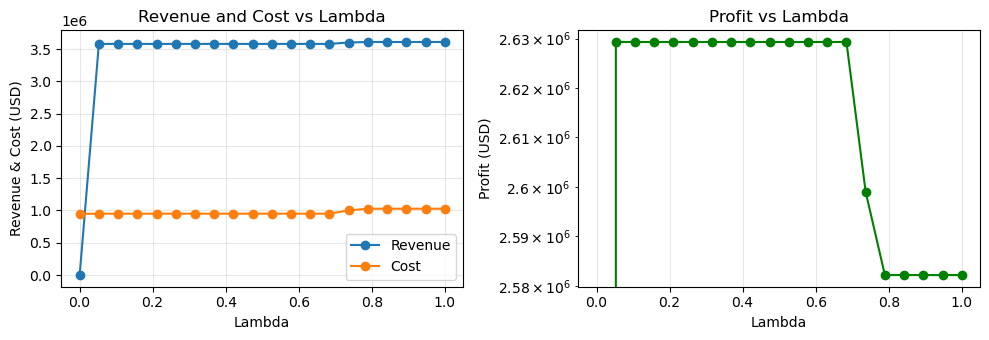

In [15]:
# Visualize lambda results
df_lam = pd.DataFrame(results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

# Revenue vs Cost
ax1.plot(df_lam['lambda'], df_lam['Revenue'], marker='o', label='Revenue')
ax1.plot(df_lam['lambda'], df_lam['Cost'], marker='o', label='Cost')
ax1.set_xlabel('Lambda')
ax1.set_ylabel('Revenue & Cost (USD)')
ax1.set_title('Revenue and Cost vs Lambda')
ax1.legend()
ax1.grid(alpha=0.3)

# Profit
ax2.plot(df_lam['lambda'], df_lam['Profit'], marker='o', color='green')
ax2.set_xlabel('Lambda')
ax2.set_ylabel('Profit (USD)')
ax2.set_title('Profit vs Lambda')
ax2.grid(alpha=0.3)

plt.yscale('log')
plt.tight_layout()
plt.show()
